In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display

In [2]:
def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [25]:
x_fn = "eat1.wav"
f_s, x = wavfile.read(x_fn)
y_fn = "eat11.wav"
f_s, y = wavfile.read(y_fn)

(40, 201)
(40, 201)


C:\Users\Hanz\AppData\Local\Temp\ipykernel_14276\3631074747.py:4: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  6.7138672e-03
  5.8288574e-03  3.5400391e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_x = librosa.feature.melspectrogram(
C:\Users\Hanz\AppData\Local\Temp\ipykernel_14276\3631074747.py:19: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ... -1.2817383e-03
 -1.6174316e-03 -1.3427734e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_y = librosa.feature.melspectrogram(


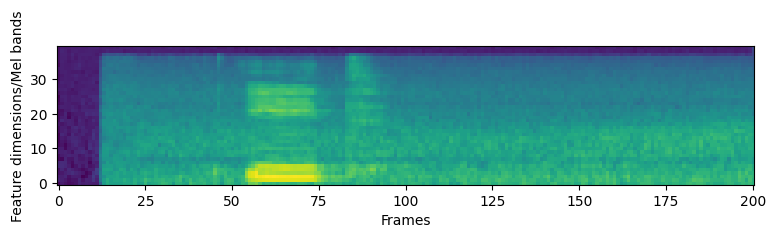

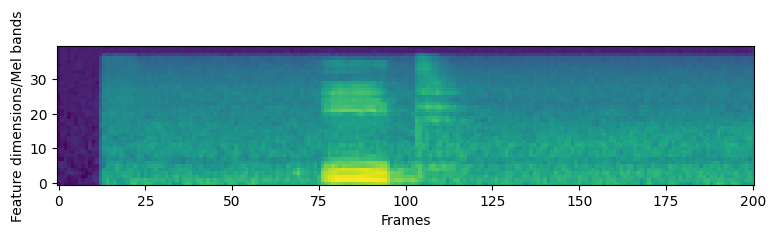

In [31]:
# Mel-scale spectrogram
n_fft = int(0.025*f_s)      # 25 ms
hop_length = int(0.01*f_s)  # 10 ms
mel_spec_x = librosa.feature.melspectrogram(
    x/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_x = np.log(mel_spec_x)

print(log_mel_spec_x.shape)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_x, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions/Mel bands")
plt.xlabel("Frames");

# Mel-scale spectrogram
mel_spec_y = librosa.feature.melspectrogram(
    y/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_y = np.log(mel_spec_y)

print(log_mel_spec_y.shape)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_y, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions/Mel bands")
plt.xlabel("Frames");

In [28]:
x_seq = log_mel_spec_x.T
y_seq = log_mel_spec_y.T

print(x_seq.shape)
print(y_seq.shape)

dist_mat = dist.cdist(x_seq, y_seq, "cosine")
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[-1, -1]))

(201, 40)
(201, 40)
Alignment cost: 0.8080


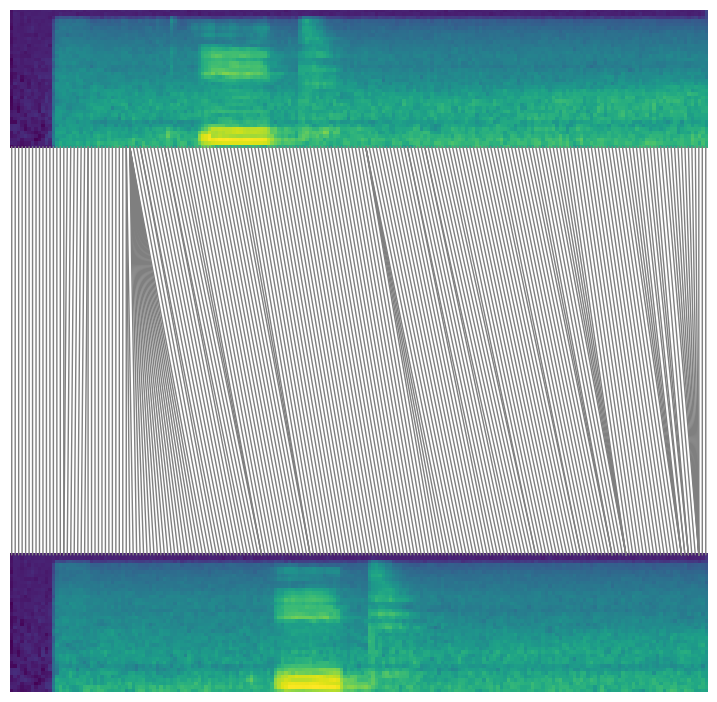

In [29]:
fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

ax1.imshow(log_mel_spec_x, origin="lower", interpolation="nearest")
ax2.imshow(log_mel_spec_y, origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, log_mel_spec_y.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

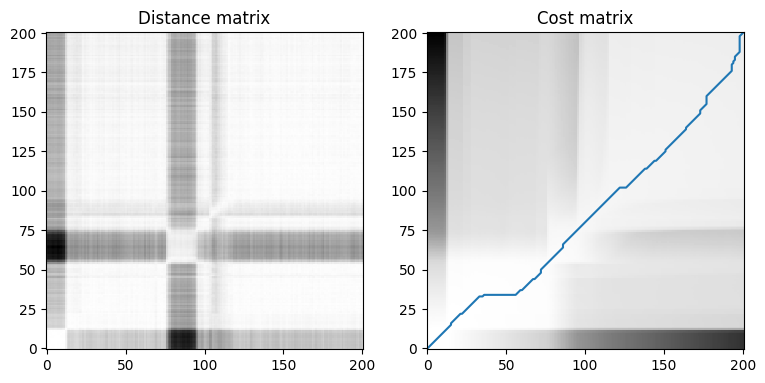

In [30]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);